# Astronomical Object Classification with Spectroscopy
The human eye has been the arbiter for the classification of astronomical sources in the night sky for hundreds of years. But a new facility -- the Large Synoptic Survey Telescope (LSST) -- is about to revolutionize the field, discovering 10 to 100 times more astronomical sources that vary in the night sky than we've ever known. 
This Convolutional Neural Network (CNN) is used to classify the different classes of astronomical objects using The Photometric LSST Astronomical
Time-series Classification Challenge (PLAsTiCC) Data set.


# Imports
We will be using PyTorch to create the Convolutional Neural Network (CNN) to classify the data.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# One Hot Encoding of Training Data
The CNN is used to classify astronomical time series data. These simulated time series, or ‘light curves’, are measurements of
an object’s brightness as a function of time - by measuring the photon flux in six different astronomical filters (commonly referred to as passbands). These passbands include
ultra-violet, optical and infrared regions of the light spectrum. There are many different
types of astronomical objects (that are driven by different physical processes) that we separate into astronomical classes. The challenge is to analyze each set of light curves (1
light curve per passband, 6 passbands per object) and determine a probability that each
object belongs to each of these classes. Therefore, we identify whether an astronomical object emits light at each of the passbands past a certain threshold brightness and use it as the inputs to our neural network. To convert the passband numbers in which the object emits a significant amount of light under the variable 'passband_numbers' to inputs to the CNN, we one hot encode the data under the variable 'passband_one_hot'.

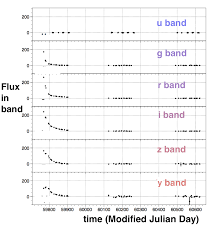

The output data which would be the class number of the astronomical object would be under the variable 'target' which will also have to be one hot encoded under the variable 'target_one_hot'

In [ ]:
#data goes here
data2 = np.array(pd.read_csv('/content/training_set.csv'))
data = np.array(pd.read_csv('/content/training_set_metadata.csv'))               


#table 1
object_id = data[1:,0]
ra = data[1:,1]
decl = data[1:,2]
gal_l = data[1:,3]
gal_b = data[1:,4]
ddf = data[1:,5]
hostgal_specz = data[1:,6]
hostgal_photos = data[1:,7]
hostgal_photos_err = data[1:,8]
distmod = data[1:,9]
MWEVB = data[1:,10]
D1 = data[1:,0:10]
target = data[1:,11]


#table 2
object_id = data2[1:,0]
mjd = data2[1:,1]
passband_number = data2[1:,2]
flux = data2[1:,3]
flux_err = data2[1:,4]
detected = data2[1:,5]
D2 = data2[1:,0:5]
print(object_id.shape)
target_one_hot = np.zeros(7849,14)
passband_one_hot = np.zeros(7849,6)

n = 0
for a in range(1048576):
  if passband_number[n] == 0 and passband_one_hot[n,4] == 0:
    passband_one_hot[n,0] += 1
  if passband_number[n] == 1 and passband_one_hot[n,0] == 0:
    passband_one_hot[n,1] += 1
  if passband_number[n] == 2 and passband_one_hot[n,1] == 0:
    passband_one_hot[n,2] += 1
  if passband_number[n] == 3 and passband_one_hot[n,2] == 0:
    passband_one_hot[n,3] += 1
  if passband_number[n] == 4 and passband_one_hot[n,3] == 0:
    passband_one_hot[n,4] += 1
  if passband_number[n] == 5 and passband_one_hot[n,4] == 0:
    passband_one_hot[n,5] += 1
  if object_id[a+1] != object_id[a]:
    n += 1

#92,88,42,90,65,16,67,95,62,15,52,6,92,64,53
for b in range(7847):
  if target[b] == 92:
    target_one_hot[b,0] += 1
  if target[b] == 88:
    target_one_hot[b,1] += 1
  if target[b] == 42:
    target_one_hot[b,2] += 1
  if target[b] == 90:
    target_one_hot[b,3] += 1
  if target[b] == 65:
    target_one_hot[b,4] += 1
  if target[b] == 16:
    target_one_hot[b,5] += 1
  if target[b] == 67:
    target_one_hot[b,6] += 1
  if target[b] == 95:
    target_one_hot[b,7] += 1
  if target[b] == 62:
    target_one_hot[b,8]
  if target[b] == 15:
    target_one_hot[b,9] += 1
  if target[b] == 52:
    target_one_hot[b,10] += 1
  if target[b] == 6:
    target_one_hot[b,11] += 1
  if target[b] == 64:
    target_one_hot[b,12] += 1
  if target[b] == 53:
    target_one_hot[b,13]


X_train = torch.from_numpy(np.concatenate((D1,D2,passband_one_hot),axis=0))
y_train = torch.from_numpy(target_one_hot)

class Inp_data(torch.utils.Dataset):
  def __init__(self):
    self.x = X_train
    self.y = y_train

  def __getitem__(self,index):
    return self.x[index],self.y[index]

  def __len__(self):
    return self.n_samples

training_set = Inp_data()
training_loader = torch.utils.data.DataLoader(training_set, batch_size=25, shuffle=True, num_workers=2)

(7847,)
(1421704,)
(1421704,)


# Creation of Convolutional Neural Network (CNN) and Training Sequence
We create a CNN with PyTorch, a machine learning framework. The model will have 6 inputs (the boolean value of the presence of a significant amount of luminousity in each of the passbands) and 14 outputs (each for a class of astronomical object) and 2 hidden layers. The Softmax activation function, Cross Entropy Loss function and Adam (adaptive moment estimation) optimiser for Gradient Descent will be used in this CNN. 

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    self.l1 = nn.Linear(21,256)
    self.l2 = nn.Linear(1024,1024)
    self.l3 = nn.Linear(1024,1024)
    self.l4 = nn.Linear(256,14)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self,x):
    out = self.l1(x)
    out = self.softmax(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    out = self.relu(out)
    out = self.l4(out)
    out = self.softmax(out)
    return out

x = passband_one_hot
x.to(device)
y = target_one_hot
y.to(device)
model = CNN(x)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimiser = torch.optim.Adam(model.parameters(),lr=learning_rate)
epochs = 20
model.to(device)

for epoch in range(epochs):
  for i, (inputs,labels) in enumerate(training_loader):
    y_predicted = model(x)
    loss = criterion(y_predicted,y)
    loss.backward()
    optimiser.step()
    print('iteration: ',i)
  if epoch == epochs:
    print('Training Complete')

torch.save(model,'/content/model')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Streaming output truncated to the last 5000 lines.
epoch:  3002
epoch:  3003
epoch:  3004
epoch:  3005
epoch:  3006
epoch:  3007
epoch:  3008
epoch:  3009
epoch:  3010
epoch:  3011
epoch:  3012
epoch:  3013
epoch:  3014
epoch:  3015
epoch:  3016
epoch:  3017
epoch:  3018
epoch:  3019
epoch:  3020
epoch:  3021
epoch:  3022
epoch:  3023
epoch:  3024
epoch:  3025
epoch:  3026
epoch:  3027
epoch:  3028
epoch:  3029
epoch:  3030
epoch:  3031
epoch:  3032
epoch:  3033
epoch:  3034
epoch:  3035
epoch:  3036
epoch:  3037
epoch:  3038
epoch:  3039
epoch:  3040
epoch:  3041
epoch:  3042
epoch:  3043
epoch:  3044
epoch:  3045
epoch:  3046
epoch:  3047
epoch:  3048
epoch:  3049
epoch:  3050
epoch:  3051
epoch:  3052
epoch:  3053
epoch:  3054
epoch:  3055
epoch:  3056
epoch:  3057
epoch:  3058
epoch:  3059
epoch:  3060
epoch:  3061
epoch:  3062
epoch:  3063
epoch:  3064
epoch:  3065
epoch:  3066
epoch:  3067
epoch:  3068
epoch:  3069
epoch:  3070
epoch:  3071
epoch:  3072
epoch:  3073
epoch:  3074


# Testing Sequence to test the accuracy of CNN
We use a seperate testing dataset to test the CNN. After selecting the exact set we will be testing under the variable 'test_set', we are able to observe  the class of astronomical object the model predicted.

In [ ]:
torch.load('/content/model')
test_data2 = np.array(pd.read_csv('/content/test_set_batch1.csv'))
test_data = np.array(pd.read_csv('/content/test_set_metadata_batch1.csv'))
passband_test = test_data[1:,2]
passband_test_one_hot = np.zeros(1421703,6)
passband_test_one_hot.to(device)
target_test = test_data[1:,0]
target_one_hot_test = np.zeros(1421703,14)
X_test = torch.from_numpy(np.concatenate((test_data[1:,0:10],test_data2[1:,0:5],passband_test_one_hot),axis=0))
y_test = torch.from_numpy(target_one_hot_test)

for c in range(1421703):
  if target_test[c] != target_test[c-1]:
    n += 1
  if passband_test[n] == 0 and passband_test_one_hot[n,0] == 0:
    passband_test_one_hot[n,0] += 1
  if passband_test[n] == 1 and passband_test_one_hot[n,1] == 0:
    passband_test_one_hot[n,1] += 1
  if passband_test[n] == 2 and passband_test_one_hot[n,2] == 0:
    passband_test_one_hot[n,2] += 1
  if passband_test[n] == 3 and passband_test_one_hot[n,3] == 0:
    passband_test_one_hot[n,3] += 1
  if passband_test[n] == 4 and passband_test_one_hot[n,4] == 0:
    passband_test_one_hot[n,4] += 1
  if passband_test[n] == 5 and passband_test_one_hot[n,5] == 0:
    passband_test_one_hot[n,5] += 1
  
for b in range(1421703):
  if target_test[b] == 92:
    target_one_hot_test[b,0] += 1
  if target_test[b] == 88:
    target_one_hot_test[b,1] += 1
  if target_test[b] == 42:
    target_one_hot_test[b,2] += 1
  if target_test[b] == 90:
    target_one_hot_test[b,3] += 1
  if target_test[b] == 65:
    target_one_hot_test[b,4] += 1
  if target_test[b] == 16:
    target_one_hot_test[b,5] += 1
  if target_test[b] == 67:
    target_one_hot_test[b,6] += 1
  if target_test[b] == 95:
    target_one_hot_test[b,7] += 1
  if target_test[b] == 62:
    target_one_hot_test[b,8]
  if target_test[b] == 15:
    target_one_hot_test[b,9] += 1
  if target_test[b] == 52:
    target_one_hot_test[b,10] += 1
  if target_test[b] == 6:
    target_one_hot_test[b,11] += 1
  if target_test[b] == 64:
    target_one_hot_test[b,12] += 1
  if target_test[b] == 53:
    target_one_hot_test[b,13]

class Out_data(torch.utils.Dataset):
  def __init__(self):
    self.x = X_test
    self.y = y_test

  def __getitem__(self,index):
    return self.x[index],self.y[index]

  def __len__(self):
    return self.n_samples

test_set = Out_data()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=25, shuffle=True, num_workers=2)
test_epoch = 1
for test_epochs in range(test_epoch):
  for i, (inputs_test,labels_test) in enumerate(test_loader):
    acc = sklearn.metrics.accuracy_score(labels_test, model[inputs_test], normalize=True, sample_weight=None)
    print('Accuracy', acc)